# Python

## Reading ACE Files
To interact with nuclear data, we first need to read in an ACE file. ACE stands for A Compact ENDF. This if the format which many Monte Carlo codes (such as MCNP and Serpent) use for nuclear data. First we need to import the PapillonNDL library into Python, then we will read in a pre-prepared data file for U235.

In [1]:
from pyPapillonNDL import *
U235ACE = ACE("92235.800nc")

With the ACE file read into memory, we can access the raw data in this manner should we so desire. We can get basic information such as whether the nuclide is fissile, the temerature at which the evaluation was prepared (given in kelvin !), and the atomic weight ratio.

In [2]:
print("U235 is fissile: %r" %U235ACE.fissile())
print("Atomic Weight Ratio of U235 is %.5f" %U235ACE.awr())
print("This evaluation was prepared at %.3f kelvin" %U235ACE.temperature())

U235 is fissile: True
Atomic Weight Ratio of U235 is 233.02480
This evaluation was prepared at 293.606 kelvin


It is also possible to access the JXS, NXS, and XSS blocks directly. All values from the JXS and NXS blocks are given as integers, while values in the XSS block are given as floats (even if they are provided as a integer in the file).

In [3]:
len_of_xss = U235ACE.nxs(0)
segment_of_xss = U235ACE.xss(0, 5)
print("Length of NXS block is %i" %len_of_xss)
print("First 5 elements of the XSS: %r" %segment_of_xss)

Length of NXS block is 7168374
First 5 elements of the XSS: [1e-11, 1.03125e-11, 1.0625e-11, 1.09375e-11, 1.125e-11]


Most of the time however, interacting with the raw ACE file is not very desireable. For ACE files which contain continuous energy neutron data, you can construct an `STNeutron` object, which allows for interaction with the data in a more natural manner. This object provides similar access to the temperature, and AWR, as well as cross sections and secondary energy distributions.

In [4]:
U235 = STNeutron(U235ACE)

## MCNP and Serpent Libraries

While it is possible to load ACE files individually to create `STNeutron` instances, this can become tedious when more nuclides or temperatures are needed. Instead, you can directly read either an MCNP or a Serpent cross section library.


In [5]:
lib = MCNPLibrary("/home/hunter/Documents/nuclear_data/lib80x/ace/lib80x.xsdir")

From a library, you can directly load a nuclide using the element symbol, and the atomic mass number of the isotope. You must also specify the desired temperature for the data, and a temperature tolerance (which is 1 Kelvin by default). If you don't know what temperatures are provided in the library, you can get a list of the provided data for the symbol:

In [6]:
lib.temperatures("U235")

[0.100000774447288,
 249.99613385916,
 293.60591295412,
 600.00000487648,
 900.00000731472,
 1200.0232187892002,
 2499.9613385916]

Let's grab the evaluation for U235 at 293.6 Kelvin:

In [7]:
U235 = lib.load_STNeutron("U235", 293.6)

## Evaluating and Plotting Cross Sections
From the `STNeutron` object, it is possible to get instances of callable `CrossSection` objects for the total, elastic, dissapearance, and fission cross sections. These facilitate the evaluation of cross sections at a provided energy (in units of MeV).

In [8]:
total_xs = U235.total_xs()
elastic_xs = U235.elastic_xs()
disappearance_xs = U235.disappearance_xs()
fission_xs = U235.fission_xs()

print("Total XS at 0.3 MeV = %.5f barns" %total_xs(0.3))
print("Elastic Scattering XS at 0.3 MeV = %.5f barns" %elastic_xs(0.3))
print("Disappearance XS at 0.3 MeV = %.5f barns" %disappearance_xs(0.3))
print("Fission XS at 0.3 MeV = %.5f barns" %fission_xs(0.3))

Total XS at 0.3 MeV = 9.74688 barns
Elastic Scattering XS at 0.3 MeV = 7.13012 barns
Disappearance XS at 0.3 MeV = 0.21780 barns
Fission XS at 0.3 MeV = 1.23070 barns


One of the most time consuming parts of looking-up a cross sections is locating the appropriate location in the energy grid. PapillonNDL implements the hashing method, which allows for a quick lookup of the energy index. This index can be provided as an optional argument, to speed up evaluations. If an energy grid index is not provided, binary search will be used to find the appropriate location in the grid.

In [9]:
indx = U235.energy_grid().get_lower_index(1.4)
print("Total XS at 1.4 MeV = %.5f barns" %total_xs(1.4, indx))

Total XS at 1.4 MeV = 6.74889 barns


It is very common to need to look up the total, elastic, fission, and absorption cross sections quite often. For this reason, a `XSPacket` class is provided, which contains these cross sections, and can be evaluated with

In [10]:
xspacket = U235.evaluate_xs(1.4, indx)
print("Total XS =", xspacket.total)
print("Elastic XS =", xspacket.elastic)
print("Inelastic XS =", xspacket.inelastic)
print("Absorption XS =", xspacket.absorption)
print("Fission XS =", xspacket.fission)

Total XS = 6.74889371
Elastic XS = 3.55468
Inelastic XS = 1.8799812289000002
Absorption XS = 1.3142324811
Fission XS = 1.2279


PapillonNDL also makes it really easy to plot cross sections. To do this, we get instances of the `CrossSection` objects which we want to plot (such as total, fission, etc.), and we can then access the data as lists.

<IPython.core.display.Javascript object>


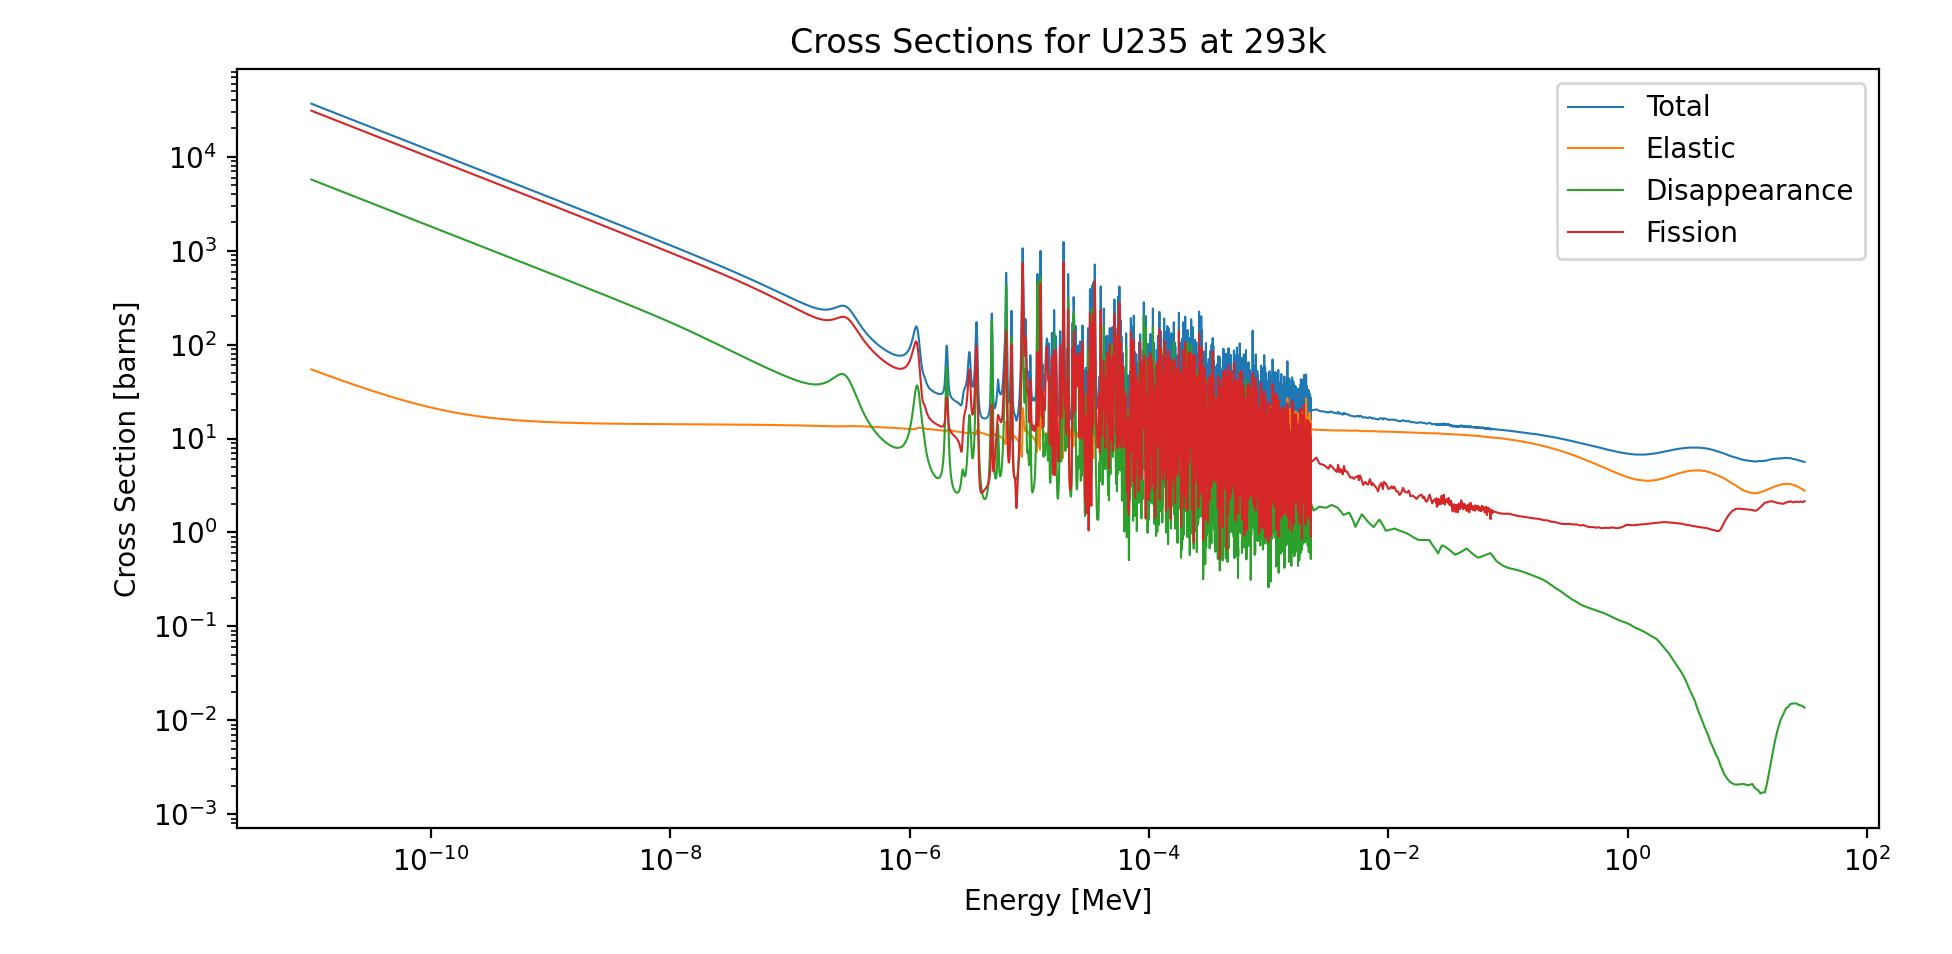

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook
energy_grid = total_xs.energy()
plt.plot(total_xs.energy(), total_xs.xs(), label='Total', linewidth=0.75)
plt.plot(elastic_xs.energy(), elastic_xs.xs(), label='Elastic', linewidth=0.75)
plt.plot(disappearance_xs.energy(), disappearance_xs.xs(), label='Disappearance', linewidth=0.75)
plt.plot(fission_xs.energy(), fission_xs.xs(), label='Fission', linewidth=0.75)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Cross Section [barns]')
plt.title('Cross Sections for U235 at %ik' %int(U235.temperature()))
plt.tight_layout()
plt.legend()

## Interacting with Reaction Data
Data which is related to a particular reaction, such as the cross section and secondary distributions, is stored in the corresponding `STReaction` class instance. You can check to see if an `STNeutron` instance has a particluar reaction MT and then get that reaction using:

In [12]:
if U235.has_reaction(16):
    n2n = U235.reaction(16)

Here, `n2n` contains all the data for the MT=16 (n,2n) reaction for U235. One should always check that a desired reaction MT is actually contained in a `STNeutron` instance with the `has_reaction` method. If you try accessing an reaction which does not exists, an exception will be thrown.

In [13]:
try:
    n4n = U235.reaction(37)
except Exception as e:
    print(str(e))


 #---------------------------------------------------------------------------------
 # File: /home/hunter/projects/papillon-ndl/include/PapillonNDL/st_neutron.hpp
 # Function: const pndl::STReaction& pndl::STNeutron::reaction(uint32_t) const
 # Line: 148
 # 
 # MT = 37 is not provided in ZAID = 92235.
 #---------------------------------------------------------------------------------



Only data related to scattering reactions which are not elastic (MT 2), and absorption reactions which are not related to fission (MT 18, 19, 20, 21, and 38) can be found with `STNeutron.has_reaction` and `STNeutron.reaction`. Because elastic scattering a fission are quite different, they are treated in a special manner, covered later on.

Once we have an `STReaction` instance, we can get the threshold energy for the reaction to occur, the yield as a function of energy, the cross section, and the secondary distributions.

In [14]:
n2n_threshold = n2n.threshold()
print("(n,2n) threshold for U235 = %.3f MeV" %n2n_threshold)

# The C++ method 'yield' cannot be used in Python as it is a keyword.
# Here, we must use the method name 'multiplicity'.
print("Yield at %.3f MeV = %.f" %(n2n_threshold,n2n.multiplicity()(n2n_threshold)))
    
n2n_xs = n2n.xs()
print("(n,2n) cross section at 6 MeV = %.3f barns" %n2n_xs(6.))

(n,2n) threshold for U235 = 5.321 MeV
Yield at 5.321 MeV = 2
(n,2n) cross section at 6 MeV = 0.184 barns


We can easily sample the secondary distributions from reactions. All that must be provided is an incident energy, and a random number generator function, and the reaction will return an `AngleEnergyPacket` which contains the sampled cosine of the scattering angle, and outgoing energy *both in the LABORATORY frame*. PapillonNDL will convert all data sampled from reactions to the lab frame automatically. While not provided in the C++ version of the library, the Python version comes with a simple random number generator function by the name of `rng`. We can use that here to sample an energy and angle.

In [15]:
scatter_data = n2n.sample_neutron_angle_energy(6., rng)
print("Cosine of scattering angle = %.5f" %scatter_data.cosine_angle)
print("Scattered energy = %.5f MeV" %scatter_data.energy)

Cosine of scattering angle = 0.55257
Scattered energy = 0.38519 MeV


We can even retrieve the angle-energy distributions for the reaction to take a closer look at the data if we want.

In [16]:
neutron_dist = n2n.neutron_distribution()
print(type(neutron_dist))

<class 'pyPapillonNDL.CMDistribution'>


Through the magic of pybind11, Python will know the true type of distribution automatically, so you know how to look at it. To learn more about all of the different distribution types, try looking at the Library API documentation.

## Elastic Scattering

Elastic scattering is somewhat peculiar, as there are many different approximation which can be made when performing the collision mechanics, to sample the outgoing energy and direction of a neutron after such a collision. The elastic data is stored in an `Elastic` instance, and can be retrieved with

In [17]:
elastic = U235.elastic()

One thing we can do is plot the elastic scattering angular distributions. We can look at the number of incident energies, and then get the `AngleLaw` corresponding to a particular incident energy.

<IPython.core.display.Javascript object>


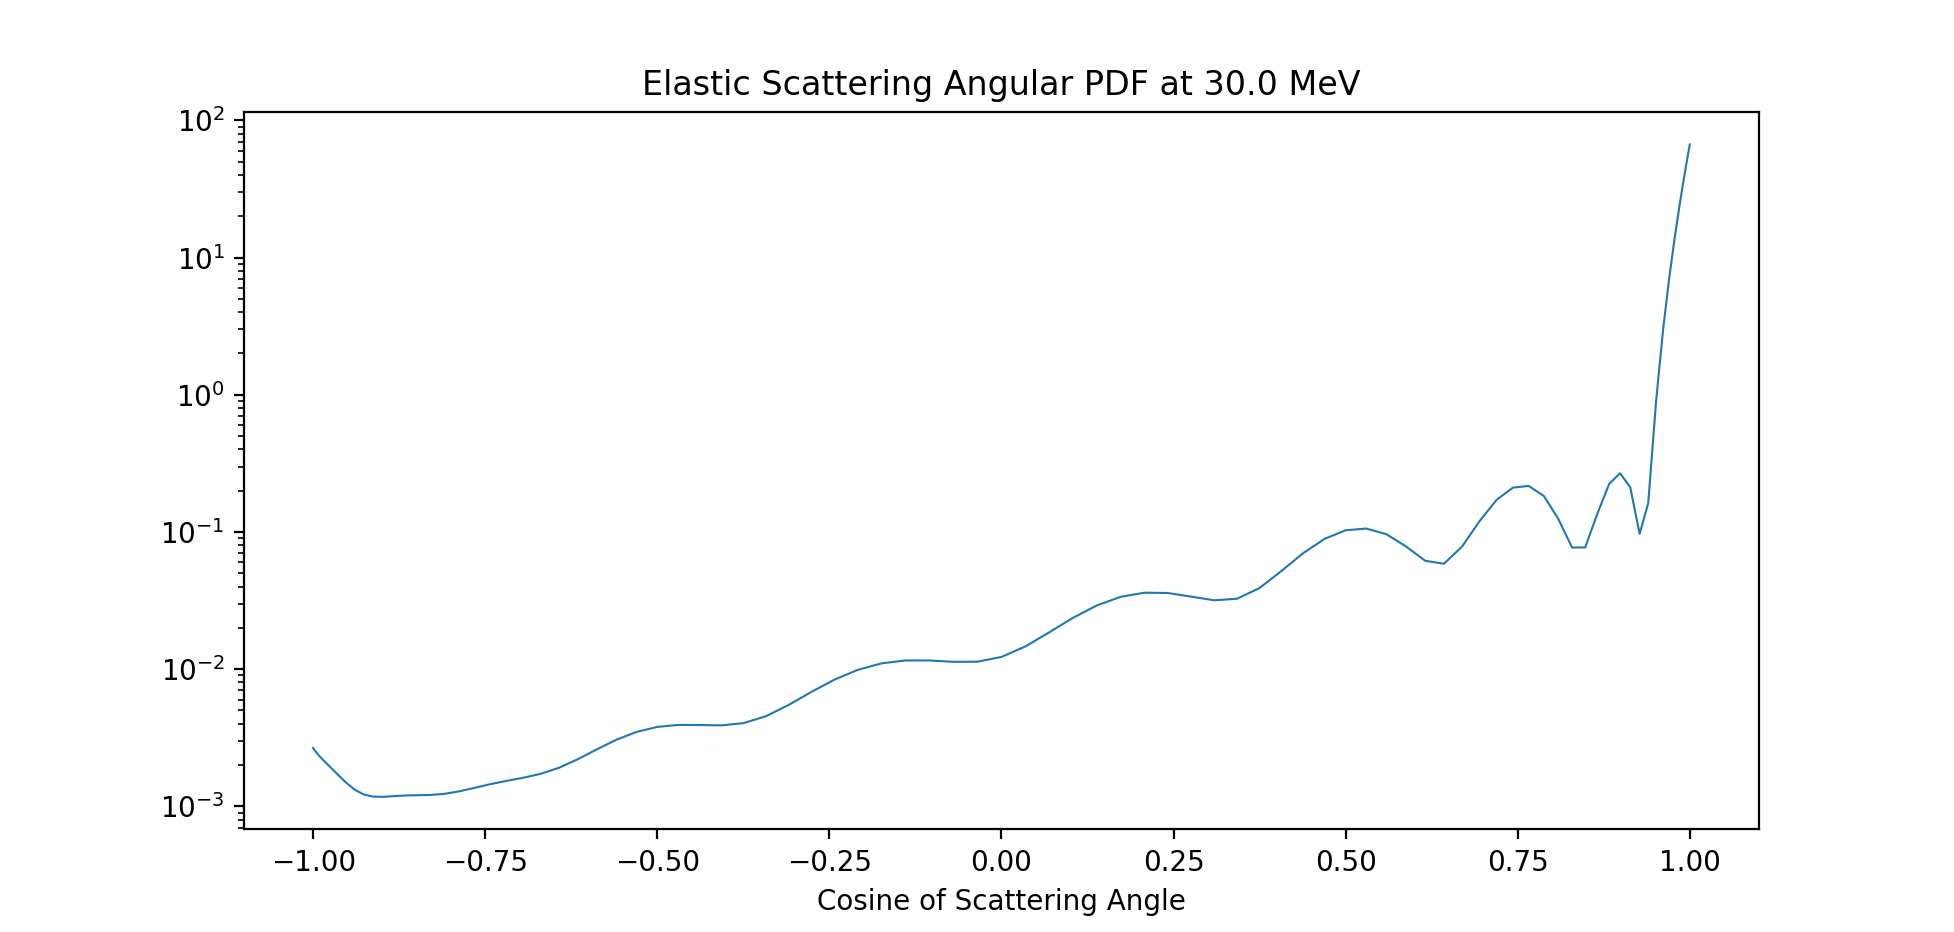

In [18]:
elastic_ad = elastic.angle_distribution()
angular_law = elastic_ad.law(elastic_ad.size()-1)
law_energy = elastic_ad.energy(elastic_ad.size()-1)

if isinstance(angular_law, AngleTable):
    plt.plot(angular_law.cosines(), angular_law.pdf(), linewidth=0.75)
    plt.yscale('log')
    plt.xlabel('Cosine of Scattering Angle')
    plt.title('Elastic Scattering Angular PDF at %.1f MeV' %law_energy)
    plt.show()

<IPython.core.display.Javascript object>


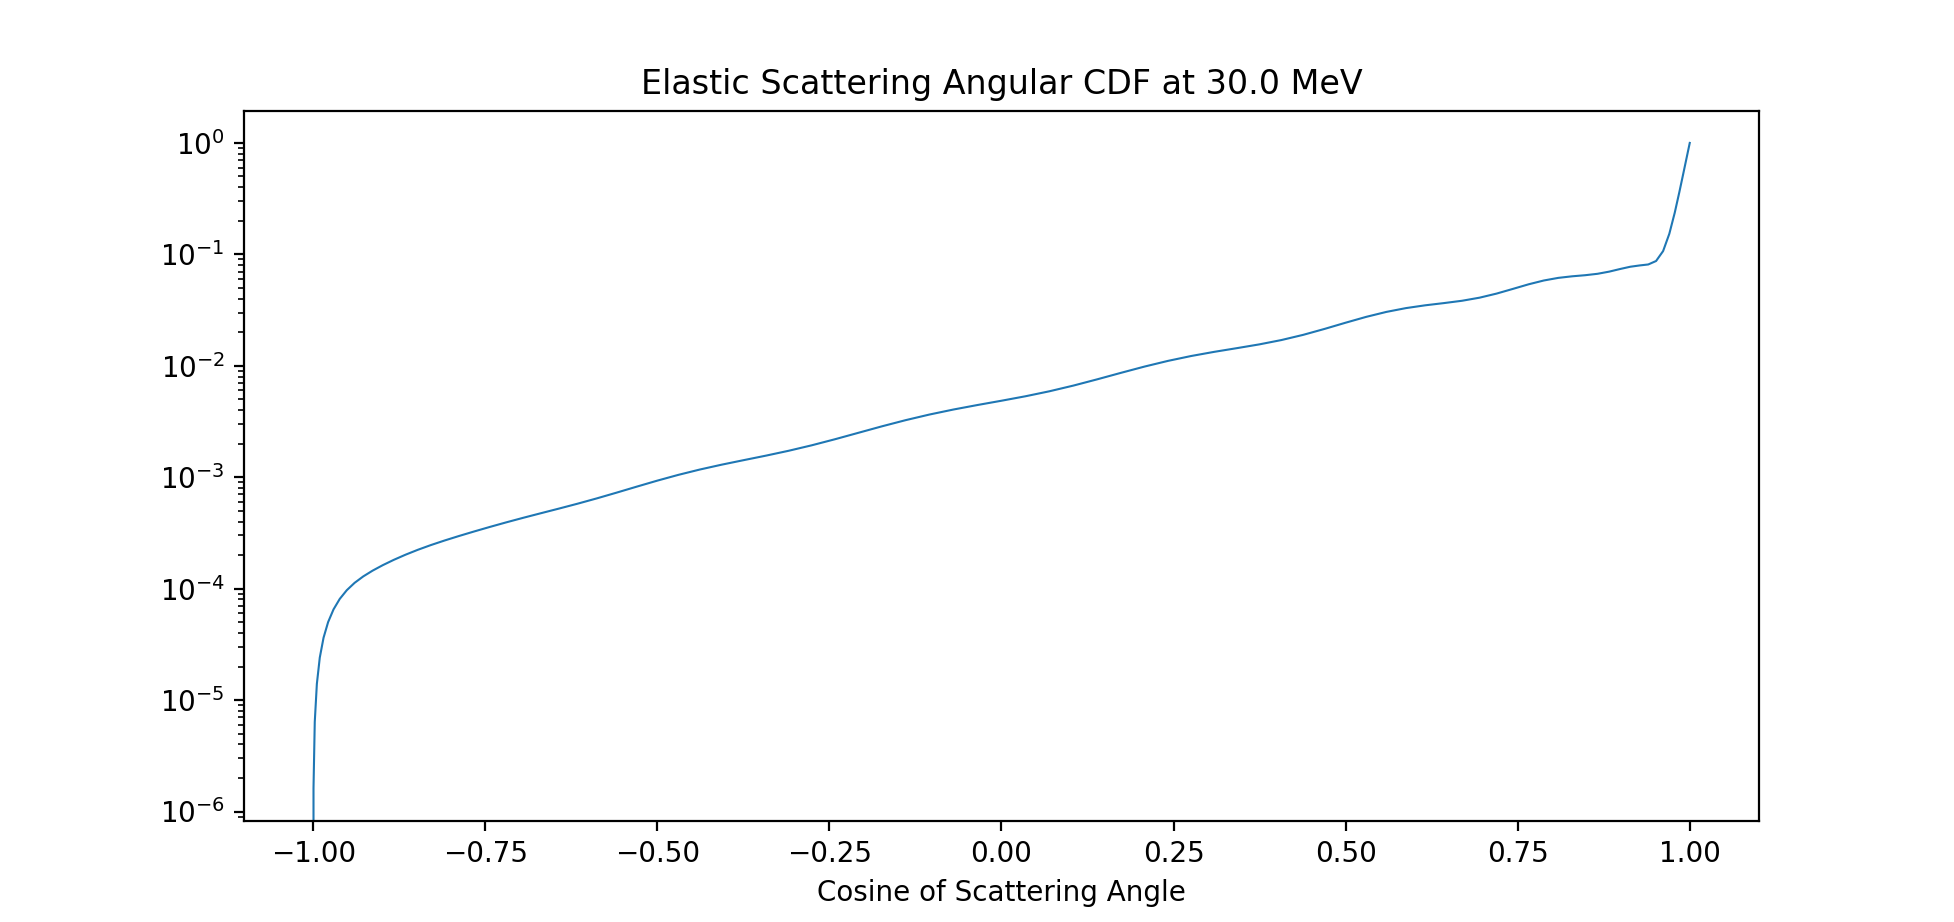

In [19]:
if isinstance(angular_law, AngleTable):
    plt.plot(angular_law.cosines(), angular_law.cdf(), linewidth=0.75)
    plt.yscale('log')
    plt.xlabel('Cosine of Scattering Angle')
    plt.title('Elastic Scattering Angular CDF at %.1f MeV' %law_energy)
    plt.show()

By default, PapillonNDL will use the Sample Target Velocity (SVT) method to sample elastic scattering. This approximation is also refered to as the Constant Cross Section (CXS) approximation. While used ubiquitously in Monte Carlo codes, it is known to give inaccurate results when used for large nucleids which have resonances at low energies. If desired, you can manally change the approximation, by giving the `Elastic` instance a new `ElasticDopplerBroadener`. The two possible broadeners are `ElasticSVT` (the default), or `ElasticDBRC`, which applied the Doppler Broadening Resonance Correction (DBRC). This method requires the 0 Kelvin elastic scattering cross section, so we will load that, and the apply DBRC to U235.

In [20]:
U235_0K = lib.load_STNeutron("U235", 0.)
elastic.set_elastic_doppler_broadener(ElasticDBRC(U235_0K.elastic_xs()))

Since the `Elastic` instance is returned by reference, chaning the Doppler Broadener in `Elastic` also changes it in the `U235` instance as well. We can verify this, as both has the same address in memory:

In [21]:
print(elastic)
print(U235.elastic())

Another approximation we can change is the use of the Target at Rest (TAR) approximation. By default, TAR is used for all nuclides when the incident energy $E_{in}$ is larger than $400kT$, where $k$ is the Boltzmann constant, and $T$ is the nuclide temperature. It is generally a good idea to use this approximation when $E_{in} > 400kT$, as it does not significantly change results, and speeds up calculations. Most codes however do not use TAR for Hydrogen-1, as it is lighter than a neutron, and using this approximation can lead to inaccurate energy transfers. You can turn off TAR with

In [22]:
elastic.set_use_tar(False)

## Fission Data and Delayed Groups
Data related to fission, such as the average number of neutrons emitted per fission, the number of delayed groups, and the delayed group information are held in the `Fission` class.

In [23]:
fission = U235.fission()
nu_tot = fission.nu_total()
nu_prmpt = fission.nu_prompt()
nu_delyd = fission.nu_delayed()

print("Total   nu at 0.005 MeV = %.3f" %nu_tot(0.005))
print("Prompt  nu at 0.005 MeV = %.3f" %nu_prmpt(0.005))
print("Delayed nu at 0.005 MeV = %.3f" %nu_delyd(0.005))

Total   nu at 0.005 MeV = 2.422
Prompt  nu at 0.005 MeV = 2.406
Delayed nu at 0.005 MeV = 0.016


<IPython.core.display.Javascript object>


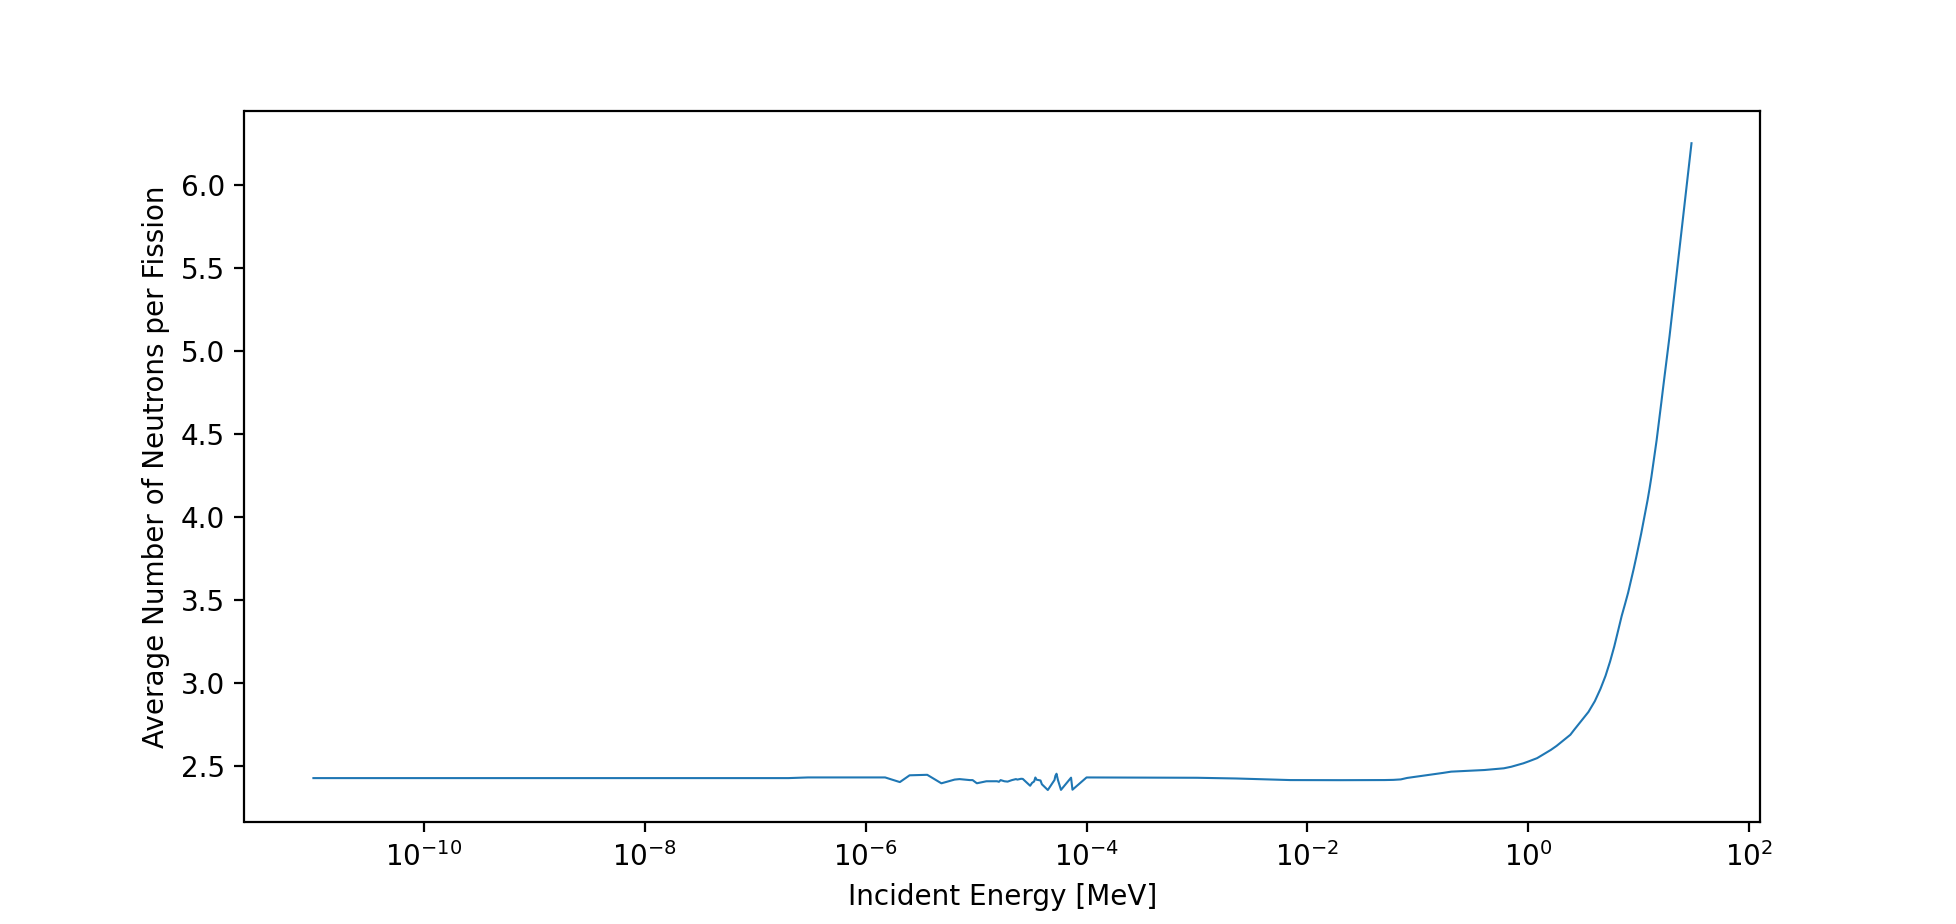

In [24]:
if isinstance(nu_tot, Tabulated1D):
    plt.plot(nu_tot.x(), nu_tot.y(), linewidth=0.75)
    plt.xlabel('Incident Energy [MeV]')
    plt.ylabel('Average Number of Neutrons per Fission')
    plt.xscale('log')
    plt.show()

The promp spectrum can be easily sampled as well.

In [25]:
prompt_ae = fission.prompt_spectrum().sample_angle_energy(0.0625E-6, rng)
print("Prompt Fission Energy: %.4f MeV" %prompt_ae.energy)

Prompt Fission Energy: 0.3256 MeV


A `DelayedFamily` contains the decay constant for precursors, and the probability that a precursor is born into that delayed family for a given incident neutron energy. This is also where you will find the energy distributions for delayed neutrons. Delayed neutrons are always isotropic, and therefore, only the energy is sampled, and not the angle.

In [26]:
print("U235 has %i delayed neutron families." %fission.n_delayed_families())

U235 has 6 delayed neutron families.


In [27]:
E = 1.E-8
df1 = fission.delayed_family(1)
print("Probability of being in group 1: %.5f" %df1.probability()(E))
print("Decaye Constant for group 1: %.5f [1/s]" %df1.decay_constant())
print("Sampled delayed neutron energy: %.5f MeV" %df1.sample_energy(E, rng))

Probability of being in group 1: 0.18070
Decaye Constant for group 1: 0.03274 [1/s]
Sampled delayed neutron energy: 0.41347 MeV


## Unresolved Resonance Region Probability Tables

At high energies, it becomes impossible to determine resonanace parameters. This region is called the Unresolved Resonance Region (URR). To correctly treat this portion of the energy spectrum, probability tables can be used. This information is stored in the `URRPTables` class. If the result of `URRPTables.is_valid()` is True, then URR data is provided, and can be used in transport.

In [28]:
urrptables = U235.urr_ptables()
urrptables.is_valid()

True

We can check the energy range of the URR with the following methods:

In [29]:
print("URR Min Energy: %.5f MeV" %urrptables.min_energy())
print("URR Max Energy: %.5f MeV" %urrptables.max_energy())

URR Min Energy: 0.00225 MeV
URR Max Energy: 0.02500 MeV


For a given energy and nuclide, a random number $\xi \in [0,1)$ must be sampled. This same random value must be used for the given nuclide, no matter the temperature, untill the neutron has undergone a collision.

In [30]:
xi = rng()
urr_xs = urrptables.evaluate_xs_band(0.01, xi)
print("Total XS =", urr_xs.total)
print("Elastic XS =", urr_xs.elastic)
print("Inelastic XS =", urr_xs.inelastic)
print("Absorption XS =", urr_xs.absorption)
print("Fission XS =", urr_xs.fission)

Total XS = 15.926382285095999
Elastic XS = 11.874071171199999
Inelastic XS = 1.729501e-05
Absorption XS = 4.052293818886
Fission XS = 2.969815052686


## Conclusions
Here, only a small taste of the PapillonNDL Python binds have been demonstrated. If you are interested in learning more, I encourage you to look at the Library API documentation. This is generated from the C++ header files, but all of the class names and methods are the same (with the exception of the C++ `STReaction` method `yield` which is called `multiplicity` in Python, as yield is a keyword in the language). It will provide more information about all of the options available for each distribution type, and how to access it.